In [1]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from scipy.cluster import hierarchy
from skimage import io
from collections import defaultdict
import numpy as np
import SPHC as sphc
import util as ut

In [2]:
imagePath = 'images/'
imageFiles = ['caneca1.jpg', 'caneca2.jpg', 'face1.jpg', 'face2.jpg', 'face3.jpg']

#SLIC Parameters:
numSegments = 500  # How many superpixels to start with - input for SLIC function

#SPHC Parameters:
segmentsToMerge =[400, 500]#  [70, 80, 90] #[100, 200, 300, 400, 480] #3 # How many superpixels to merge based on color similarity
distance_limit = 0.3 # Limits which segments get merged based on their difference in average color

In [3]:
'''
for file in imageFiles:
    image = img_as_float(io.imread((imagePath + file)))
    
    #segments = felzenszwalb(image, scale=200, sigma=0.5, min_size=20)
    segments = slic(image, slic_zero = True)
    
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    ax.imshow(mark_boundaries(image, segments))
    ax.set_title("SLIC's method")
    plt.show()
'''

'\nfor file in imageFiles:\n    image = img_as_float(io.imread((imagePath + file)))\n    \n    #segments = felzenszwalb(image, scale=200, sigma=0.5, min_size=20)\n    segments = slic(image, slic_zero = True)\n    \n    fig, ax = plt.subplots(1,1, figsize=(10, 10))\n    ax.imshow(mark_boundaries(image, segments))\n    ax.set_title("SLIC\'s method")\n    plt.show()\n'

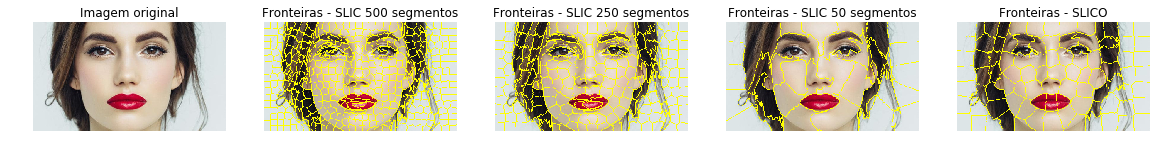

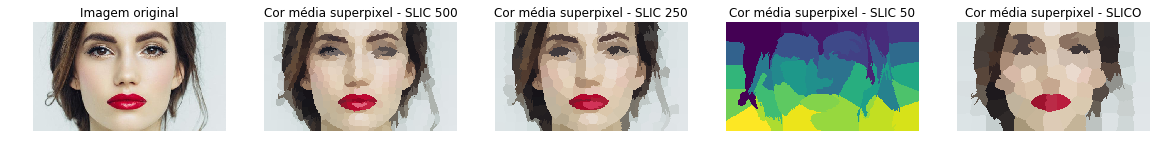

In [4]:
for file in imageFiles[2:3]:
    image = img_as_float(io.imread((imagePath + file)))
    
    #slic 500 segments
    seg_slic500 = slic(image, n_segments = 500, slic_zero = False)
    bound_slic500 = mark_boundaries(image, seg_slic500)
    slic500 = ut.merge_superpixels_colors(image, seg_slic500)
    
    #slic 250 segments
    seg_slic250 = slic(image, n_segments = 250, slic_zero = False)
    bound_slic250 = mark_boundaries(image, seg_slic250)
    slic250 = ut.merge_superpixels_colors(image, seg_slic250)
    
    #slic 50 segments
    seg_slic50 = slic(image, n_segments = 50, slic_zero = False)
    bound_slic50 = mark_boundaries(image, seg_slic50)
    slic50 = ut.merge_superpixels_colors(image, seg_slic250)
    
    #slico image
    seg_slico = slic(image, slic_zero = True)
    bound_slico = mark_boundaries(image, seg_slico)
    slico = ut.merge_superpixels_colors(image, seg_slico)
    
    #plot boundaries
    images = [image, bound_slic500, bound_slic250, bound_slic50, bound_slico]
    labels = ["Imagem original", "Fronteiras - SLIC 500 segmentos", "Fronteiras - SLIC 250 segmentos", 
             "Fronteiras - SLIC 50 segmentos", "Fronteiras - SLICO"]
    ut.plot_compare_5(images, labels, True)
    
    #plot images
    images = [image, slic500, slic250, seg_slic50, slico]
    labels = ["Imagem original", "Cor média superpixel - SLIC 500", "Cor média superpixel - SLIC 250", 
             "Cor média superpixel - SLIC 50", "Cor média superpixel - SLICO"]
    ut.plot_compare_5(images, labels, True)

In [82]:
image = img_as_float(io.imread((imagePath + imageFiles[2])))
segments = slic(image, slic_zero = True)

n_seg = 0

for segs in segments:
    curr_max = max(segs)
    if(curr_max > n_seg):
        n_seg = curr_max

n_seg += 1

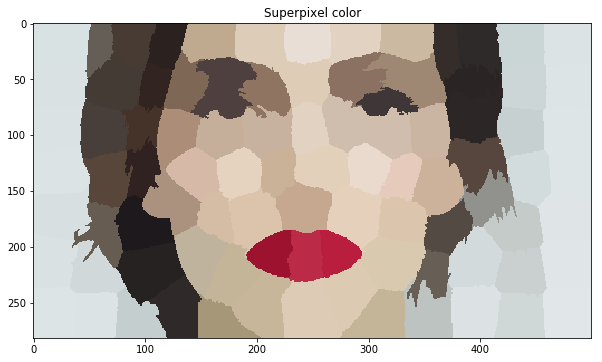

In [83]:
colors = [[.0, .0, .0] for x in range(n_seg)]
itens = [0 for x in range(n_seg)]
new_image = copy.deepcopy(image)

#replace colors
for i in range(len(segments)):
    for j in range(len(segments[i])):
        index = segments[i][j]
        colors[index] += image[i][j]
        itens[index] += 1
        
for i in range(len(itens)):
    if(itens[i] > 0):
        colors[i] = [x / itens[i] for x in colors[i]]
        
for i in range(len(segments)):
    for j in range(len(segments[i])):
        index = segments[i][j]
        new_image[i][j] = colors[index]
        
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(new_image)
ax.set_title("Superpixel color")
plt.show() 

In [143]:
Z = hierarchy.linkage(colors)
print(Z.shape)
print(segments.shape)

(90, 4)
(282, 500)


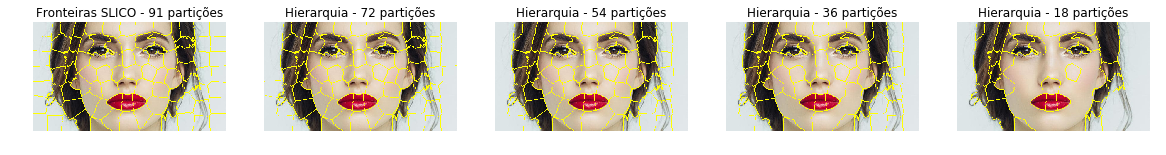

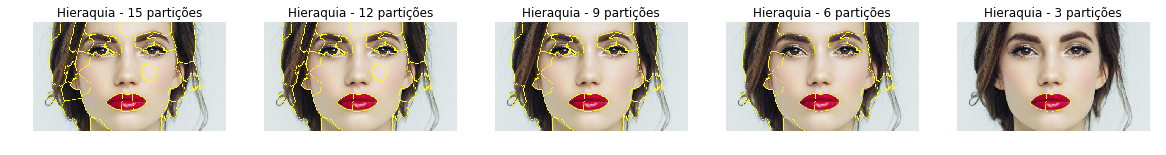

In [154]:
it = 5
step = int(n_seg/it)
cutz_images = []
cutz_labels = []

cutz_images.append(mark_boundaries(image, segments))
cutz_labels.append("Fronteiras SLICO - " + str(n_seg) + " partições")

for ix in range(it-1, 0, -1):
    cluster_size= ix * step
 
    cutz = hierarchy.cut_tree(Z, n_clusters = cluster_size)
    cutz_segs = copy.deepcopy(segments)

    for i in range(len(segments)):
        for j in range(len(segments[i])):
            index = segments[i][j]
            cutz_segs[i][j] = cutz[index][0]

    cutz_images.append(mark_boundaries(image, cutz_segs))
    cutz_labels.append("Hierarquia - " + str(cluster_size) + " partições")
    
ut.plot_compare_5(cutz_images, cutz_labels, True)

##################
it = 5
step = int(n_seg/it)
cutz_images = []
cutz_labels = []

for ix in range(it, 0, -1):
    cluster_size= ix * 3
 
    cutz = hierarchy.cut_tree(Z, n_clusters = cluster_size)
    cutz_segs = copy.deepcopy(segments)

    for i in range(len(segments)):
        for j in range(len(segments[i])):
            index = segments[i][j]
            cutz_segs[i][j] = cutz[index][0]

    cutz_images.append(mark_boundaries(image, cutz_segs))
    cutz_labels.append("Hieraquia - " + str(cluster_size) + " partições")
    
ut.plot_compare_5(cutz_images, cutz_labels, True)

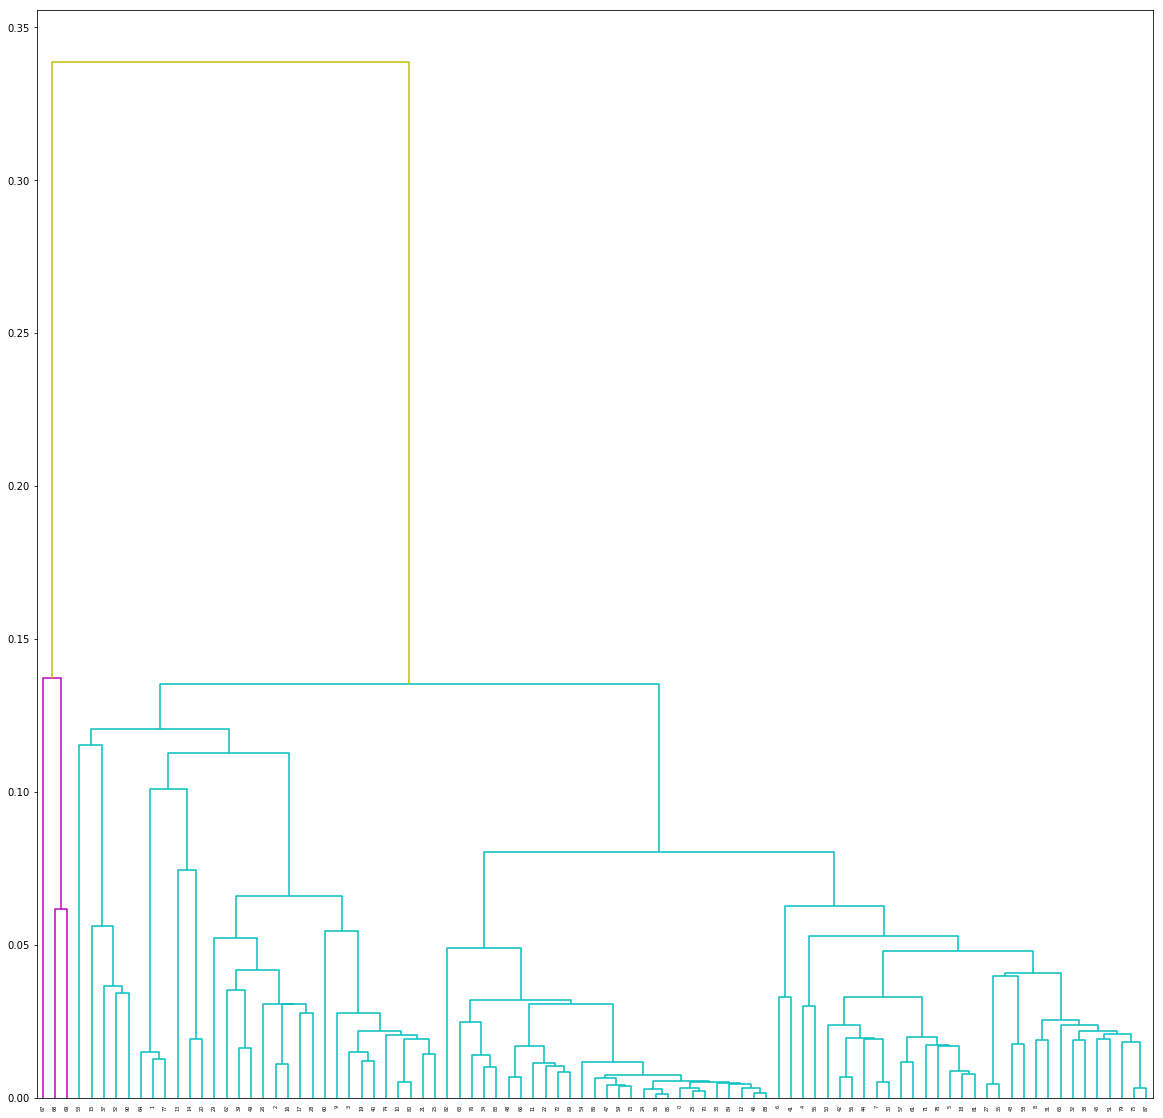

In [149]:
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig = plt.subplots(1, 1, figsize=(20,20))
dn1 = hierarchy.dendrogram(Z, above_threshold_color='y', count_sort='ascending', show_contracted = True)
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [146]:
segm_size = 87
segm_grid = sphc.getSPHCsegments(segments, image, numToMerge = segm_size, max_dist = distance_limit)

Initiating Segment Attributes...
Merging Segments...
20 segments merged
40 segments merged
60 segments merged
77 segments merged - final


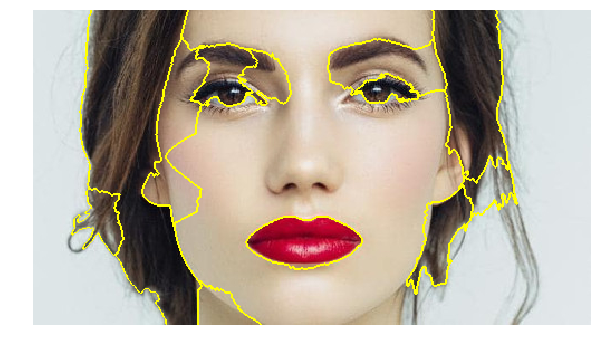

In [147]:
fig = plt.figure("Segments", figsize = (10,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(mark_boundaries(image, segm_grid))
plt.axis("off")
plt.show()